# 1. Import Libraries

In [ ]:
# import system libs
import os

# from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# import Deep learning Libraries
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, classification_report


import warnings
warnings.filterwarnings("ignore")

# 2. Helper Functions


In [ ]:
def train_and_evaluate_model(model, train_gen, valid_gen, test_gen, augmentation_type, epochs=50):
    """
    Train model and visualize results for a specific augmentation strategy
    """
    history = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=epochs,
        verbose=1
    )

    # plot and get metrics
    metrics = plot_training_history(history, augmentation_type)

    # get precision and recall
    predicted_classes, true_classes = get_predictions(model, test_gen)
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')

    metrics.update({
        'test_precision': precision,
        'test_recall': recall,
        'test_f1': f1
    })

    return history, metrics


In [ ]:
def plot_training_history(history, augmentation_type):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch = {str(index_loss + 1)}'
    acc_label = f'best epoch = {str(index_acc + 1)}'

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title(f'{augmentation_type} Augmentation - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title(f'{augmentation_type} Augmentation - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    metrics = {
        'best_val_loss': val_lowest,
        'best_val_loss_epoch': index_loss + 1,
        'best_val_acc': acc_highest,
        'best_val_acc_epoch': index_acc + 1
    }

    return metrics


In [ ]:
def get_predictions(model, generator):
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = generator.classes
    return predicted_classes, true_classes

def evaluate_model(model, generator, class_names):
    predicted_classes, true_classes = get_predictions(model, generator)

    # get detailed metrics
    precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes)

    # print classification report
    print(classification_report(true_classes, predicted_classes, target_names=class_names))

    return precision, recall, f1, support

In [ ]:
def confusion_matrix_plot(test_gen, y_predict):
  y_pred = np.argmax(y_predict, axis=1)

  # get class indices and labels
  class_indices = test_gen.class_indices
  classes = list(class_indices.keys())

  # compute confusion matrix
  cm = confusion_matrix(test_gen.classes, y_pred)

  plt.figure(figsize=(10, 10))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()

  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  threshold = cm.max() / 2.0
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(
          j, i, f"{cm[i, j]}",
          horizontalalignment='center',
          color='white' if cm[i, j] > threshold else 'black'
      )

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()

# 3. Load Data

## 3.1 Loading from Kaggle

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andrewmvd_lung_and_colon_cancer_histopathological_images_path = kagglehub.dataset_download('andrewmvd/lung-and-colon-cancer-histopathological-images')

print('Data source import complete.')


100%|██████████| 1.76G/1.76G [00:18<00:00, 99.5MB/s]

Extracting files...


Data source import complete.


In [ ]:
print(andrewmvd_lung_and_colon_cancer_histopathological_images_path)

/root/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1


In [ ]:
print(os.listdir(andrewmvd_lung_and_colon_cancer_histopathological_images_path))

['lung_colon_image_set']


## 3.2 Joining Images

In [ ]:
data_dir = '/root/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1/lung_colon_image_set'

file_paths = []
labels = []

folders = os.listdir(data_dir)

for folder in folders:
    sub_folder_path = os.path.join(data_dir, folder)
    sub_folder = os.listdir(sub_folder_path)

    for sfolder in sub_folder:
        s_sub_folder_path = os.path.join(sub_folder_path, sfolder)
        file_list = os.listdir(s_sub_folder_path)

        for file in file_list:
            fpath = os.path.join(s_sub_folder_path, file)

            file_paths.append(fpath)
            labels.append(sfolder)


FSeries = pd.Series(file_paths, name='filepaths')
LSeries = pd.Series(labels, name='labels')

df = pd.concat([FSeries, LSeries], axis=1)

## 3.3 Split Data

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['labels'])

valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['labels'])

# 4. Preprocessing

## 4.1 Helper Function

In [ ]:
# Function to create data generators for each augmentation pipeline
def create_data_generators(train_df, valid_df, test_df, augmentation_pipeline):
    train_generator = augmentation_pipeline.flow_from_dataframe(
        dataframe=train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    # Validation and test generators use only rescaling
    valid_test_generator = ImageDataGenerator(rescale=1./255)

    valid_generator = valid_test_generator.flow_from_dataframe(
        dataframe=valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = valid_test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, valid_generator, test_generator

## 4.2 Data Augmentation

In [ ]:
# Define image size and batch size
IMG_SIZE = 224  # Standard size for many CNN architectures
BATCH_SIZE = 32

### 4.2.1 Basic Augmentation

In [ ]:
# Basic Augmentation Pipeline
# Focuses on basic geometric transformations
basic_augmentation = ImageDataGenerator(
    rescale=1./255
)

# Create generators for each augmentation pipeline
basic_train_gen, basic_valid_gen, basic_test_gen = create_data_generators(
    train_df, valid_df, test_df, basic_augmentation)

Found 17500 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.


### 4.2.2 Moderate Augmentation

In [ ]:
# Moderate Augmentation Pipeline
# Adds intensity transformations while preserving tissue characteristics
moderate_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True
)

moderate_train_gen, moderate_valid_gen, moderate_test_gen = create_data_generators(
    train_df, valid_df, test_df, moderate_augmentation)


Found 17500 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.


### 4.2.3 Advanced Augmentation

In [ ]:
# Advanced Augmentation Pipeline
# Includes color transformations suitable for histopathology
advanced_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=3,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    vertical_flip=True
)

advanced_train_gen, advanced_valid_gen, advanced_test_gen = create_data_generators(
    train_df, valid_df, test_df, advanced_augmentation
)

Found 17500 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.


# 5. Model Initialization

 ## 5.1 Customized VGG16

In [ ]:
def create_model():
  img_size = (224, 224)
  channels = 3
  img_shape = (img_size[0], img_size[1], channels)
  class_count = len(list(basic_train_gen.class_indices.keys()))

  model = Sequential([
      #block 1
      Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
      Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
      MaxPool2D((2, 2)),

      #block 2
      Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
      Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
      MaxPool2D((2, 2)),

      #block 3
      Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
      Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
      Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
      MaxPool2D((2, 2)),

      #block 4
      Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
      Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
      Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
      MaxPool2D((2, 2)),

      #block 5
      Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
      Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
      Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
      MaxPool2D((2, 2)),

      Flatten(),
      Dense(256,activation = "relu"),
      Dense(64,activation = "relu"),
      Dense(class_count, activation = "softmax")
  ])

  model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
  model.summary()
  return model

## 5.2 Model Training

### 5.2.1 Training Basic Augmentation

In [ ]:
model_basic = create_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,154,245 (80.70 MB)

 Trainable params: 21,154,245 (80.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 341s 558ms/step - accuracy: 0.4692 - loss: 1.1869 - val_accuracy: 0.8656 - val_loss: 0.3534
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 263s 481ms/step - accuracy: 0.8728 - loss: 0.3251 - val_accuracy: 0.9088 - val_loss: 0.2351
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 262s 478ms/step - accuracy: 0.9204 - loss: 0.2178 - val_accuracy: 0.8920 - val_loss: 0.3872
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 262s 479ms/step - accuracy: 0.9384 - loss: 0.1653 - val_accuracy: 0.9395 - val_loss: 0.1654
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 262s 479ms/step - accuracy: 0.9590 - loss: 0.1130 - val_accuracy: 0.9669 - val_loss: 0.0845
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 323s 482ms/step - accuracy: 0.9599 - loss: 0.1026 - val_accuracy: 0.9763 - val_loss: 0.0700
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 262s 479ms/step - accuracy: 0.9655 - loss: 0.0913 - val_accuracy: 0.9635 - val_loss: 0.1025
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 262s 479ms/step - accuracy: 0.9735 -

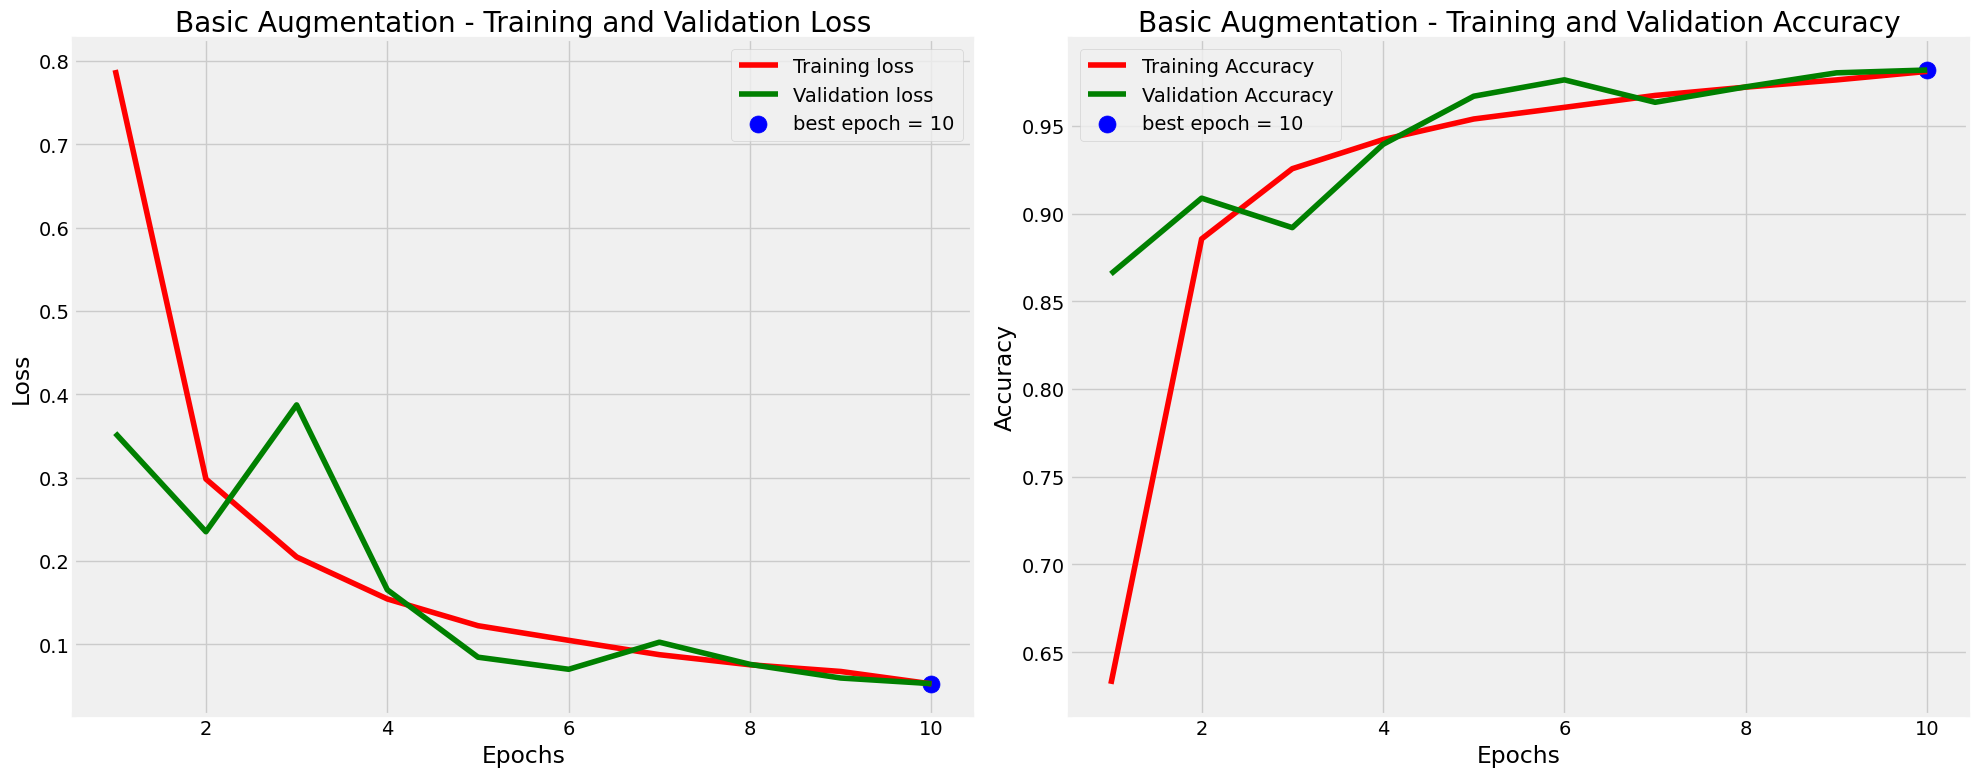

118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 181ms/step


In [ ]:
hist_basic, metrics_basic = train_and_evaluate_model(model_basic, basic_train_gen, basic_valid_gen, basic_test_gen, 'Basic', epochs=10)

118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step


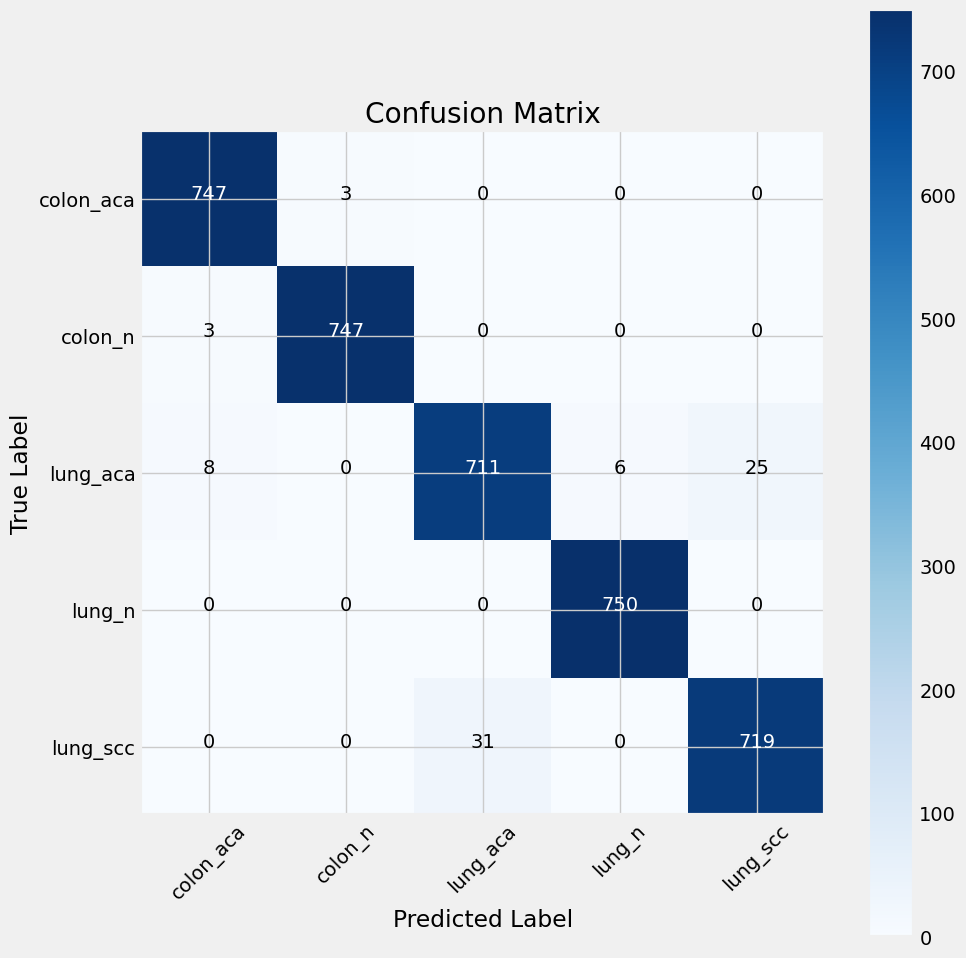

In [ ]:
y_predict_basic = model_basic.predict(basic_test_gen)
confusion_matrix_plot(basic_test_gen, y_predict_basic)

### 5.2.2 Training Moderate Augmentation

In [ ]:
model_moderate = create_model()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,154,245 (80.70 MB)

 Trainable params: 21,154,245 (80.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 345s 617ms/step - accuracy: 0.3990 - loss: 1.3492 - val_accuracy: 0.8101 - val_loss: 0.5384
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 338s 617ms/step - accuracy: 0.8343 - loss: 0.4274 - val_accuracy: 0.9013 - val_loss: 0.2718
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 340s 622ms/step - accuracy: 0.9092 - loss: 0.2459 - val_accuracy: 0.9163 - val_loss: 0.2368
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 334s 611ms/step - accuracy: 0.9344 - loss: 0.1816 - val_accuracy: 0.9376 - val_loss: 0.1687
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 332s 607ms/step - accuracy: 0.9432 - loss: 0.1533 - val_accuracy: 0.9461 - val_loss: 0.1388
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 330s 603ms/step - accuracy: 0.9593 - loss: 0.1118 - val_accuracy: 0.9413 - val_loss: 0.2120
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 335s 612ms/step - accuracy: 0.9587 - loss: 0.1226 - val_accuracy: 0.9619 - val_loss: 0.0977
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 334s 610ms/step - accuracy: 0.9655 -

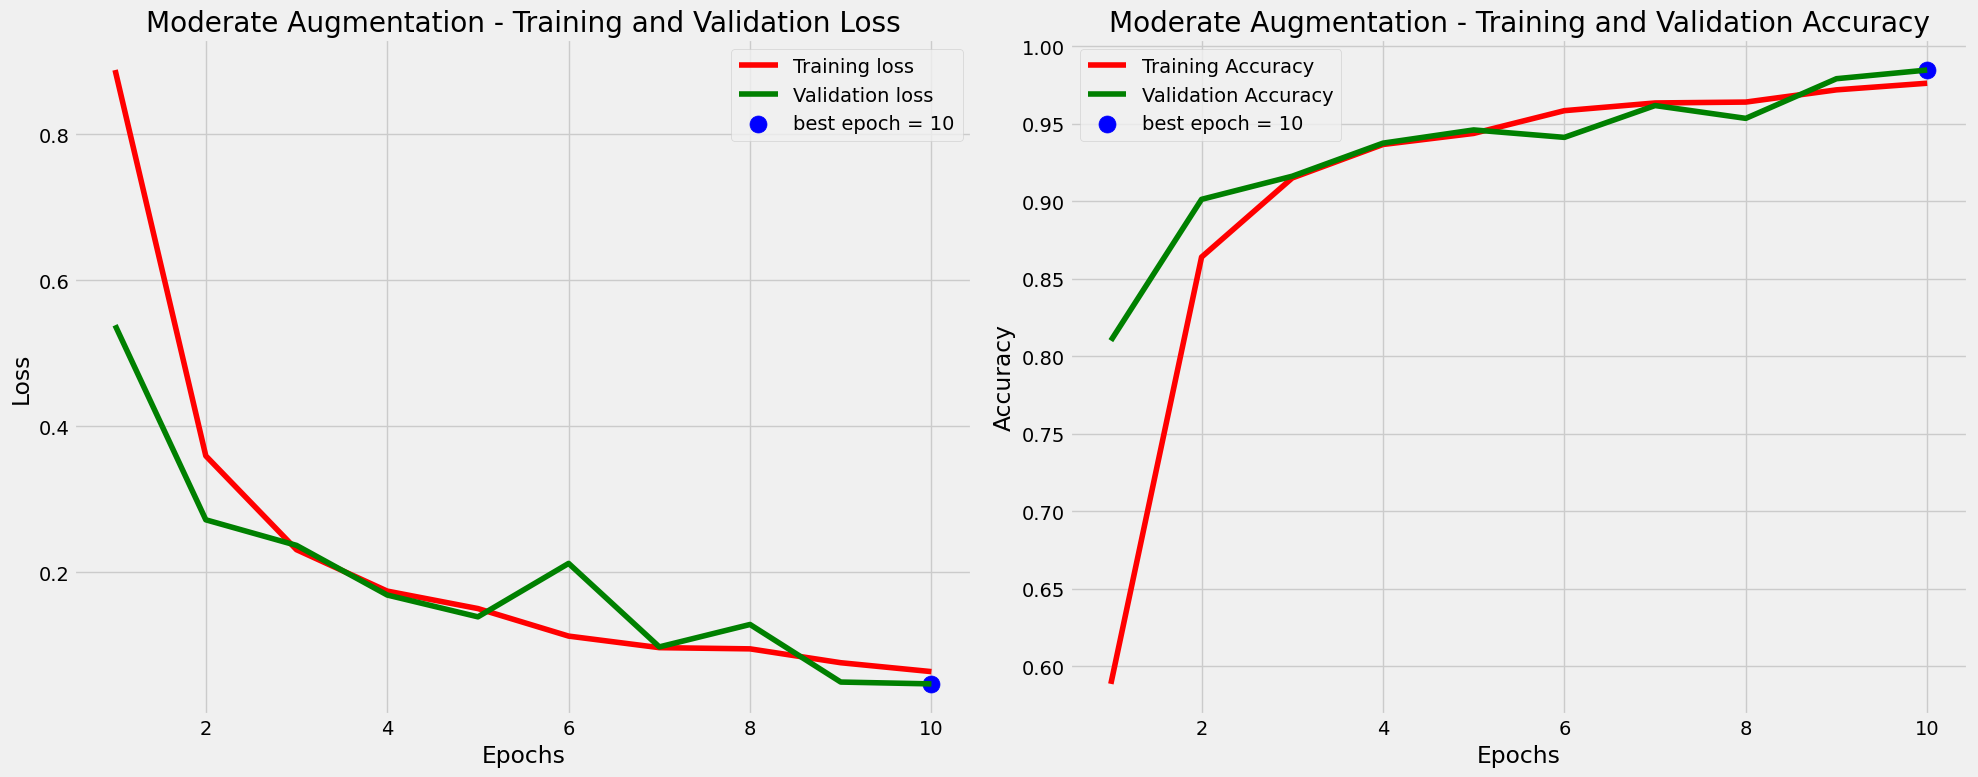

118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step


In [ ]:
hist_moderate, metrics_moderate = train_and_evaluate_model(model_moderate, moderate_train_gen, moderate_valid_gen, moderate_test_gen, "Moderate", epochs= 10)

118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step


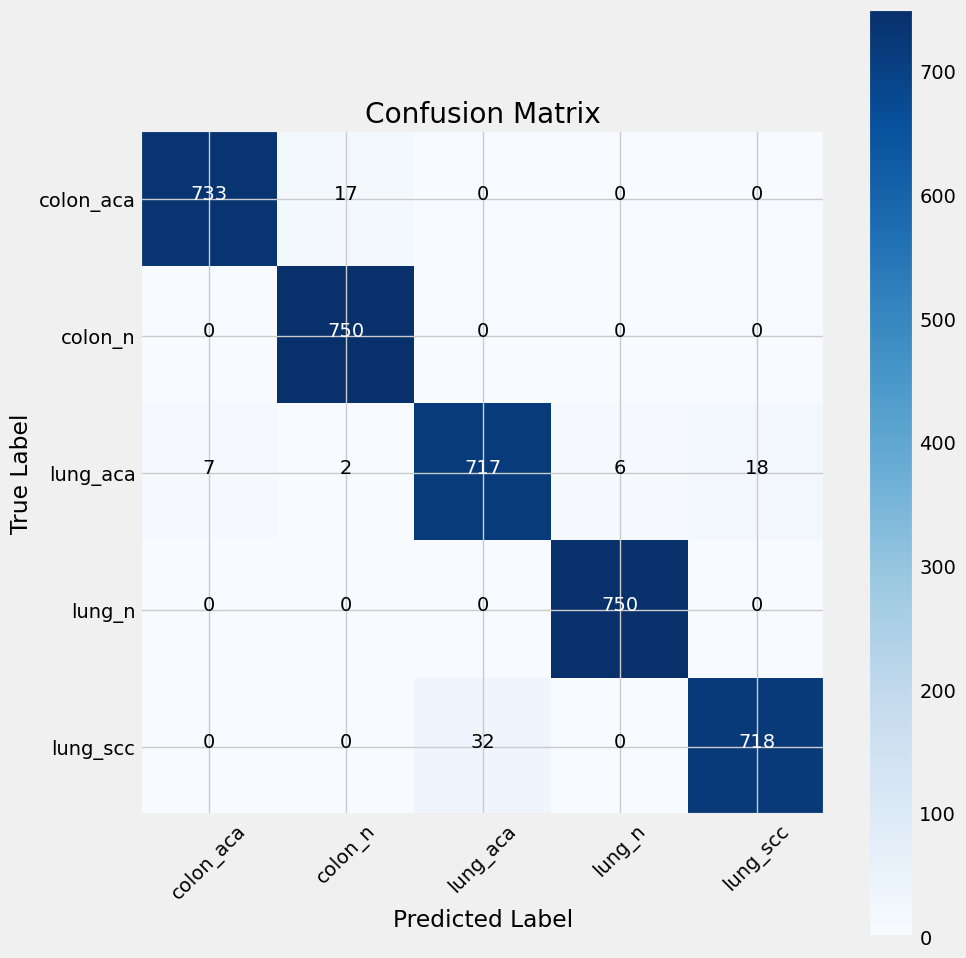

In [ ]:
y_predict_moderate = model_moderate.predict(moderate_test_gen)
confusion_matrix_plot(moderate_test_gen, y_predict_moderate)

### 5.2.3 Training Advanced Augmentation

In [ ]:
model_advanced = create_model()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,154,245 (80.70 MB)

 Trainable params: 21,154,245 (80.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 355s 626ms/step - accuracy: 0.3468 - loss: 1.4124 - val_accuracy: 0.8416 - val_loss: 0.4113
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 334s 610ms/step - accuracy: 0.8265 - loss: 0.4104 - val_accuracy: 0.8747 - val_loss: 0.3110
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 335s 612ms/step - accuracy: 0.8820 - loss: 0.3022 - val_accuracy: 0.9107 - val_loss: 0.2284
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 338s 618ms/step - accuracy: 0.9054 - loss: 0.2406 - val_accuracy: 0.9251 - val_loss: 0.1841
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 376s 607ms/step - accuracy: 0.9275 - loss: 0.1895 - val_accuracy: 0.9504 - val_loss: 0.1604
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 335s 613ms/step - accuracy: 0.9404 - loss: 0.1653 - val_accuracy: 0.9651 - val_loss: 0.1048
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 384s 615ms/step - accuracy: 0.9477 - loss: 0.1379 - val_accuracy: 0.9648 - val_loss: 0.1008
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 338s 618ms/step - accuracy: 0.9549 -

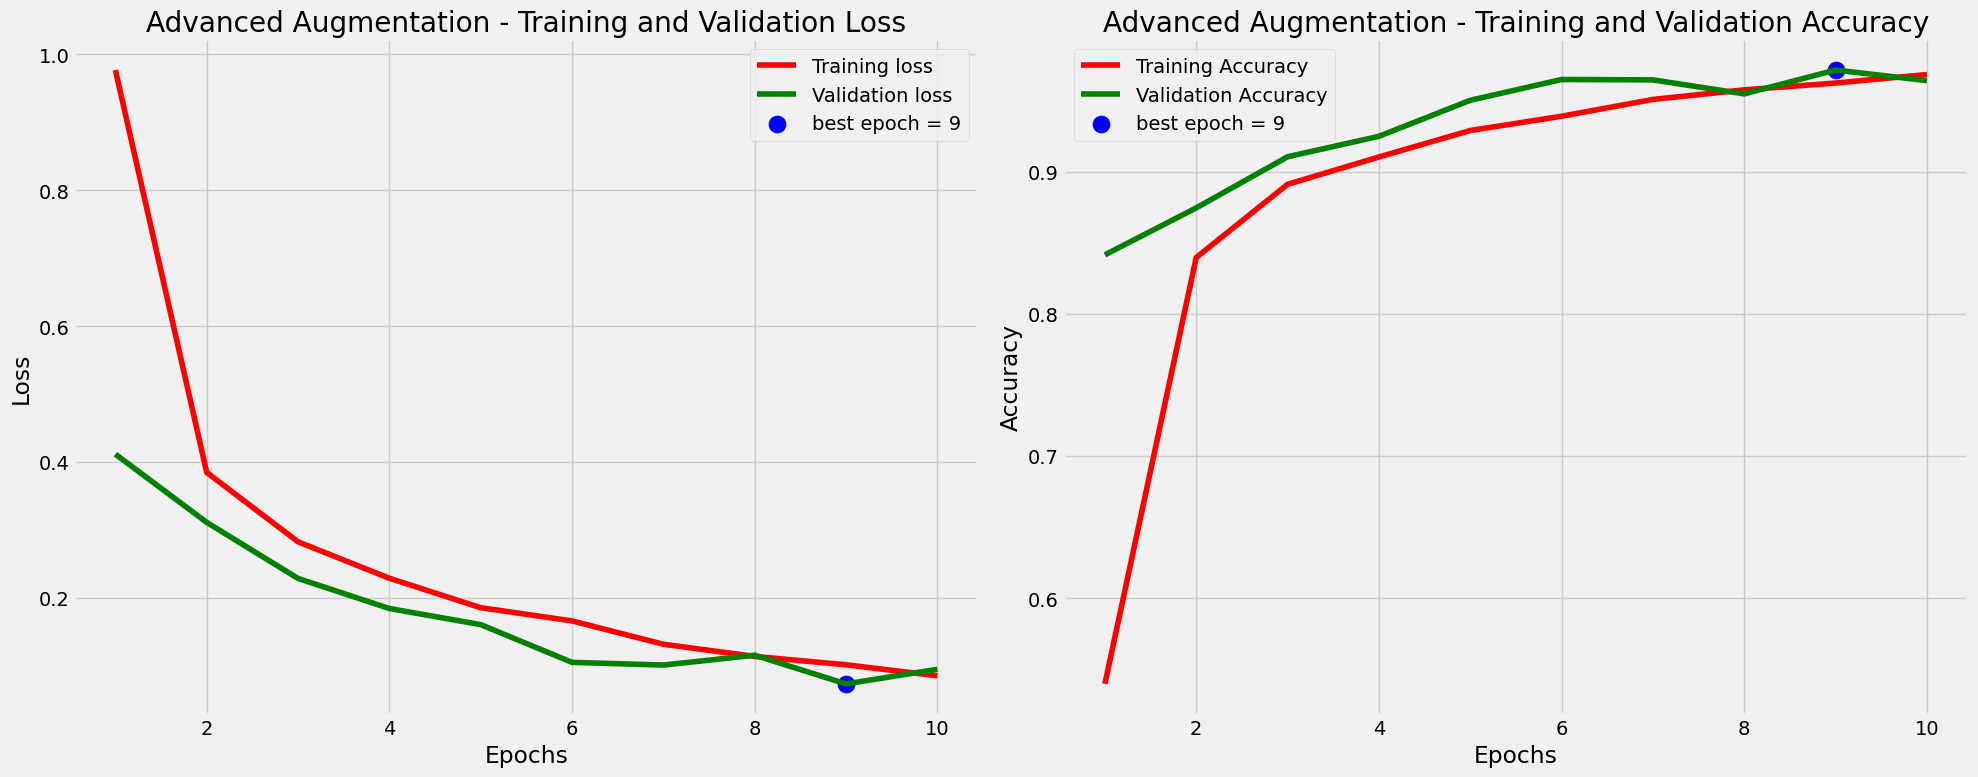

118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step


In [ ]:
hist_advanced, metrics_advanced = train_and_evaluate_model(model_advanced, advanced_train_gen, advanced_valid_gen, advanced_test_gen, "Advanced", epochs=10)

118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 175ms/step


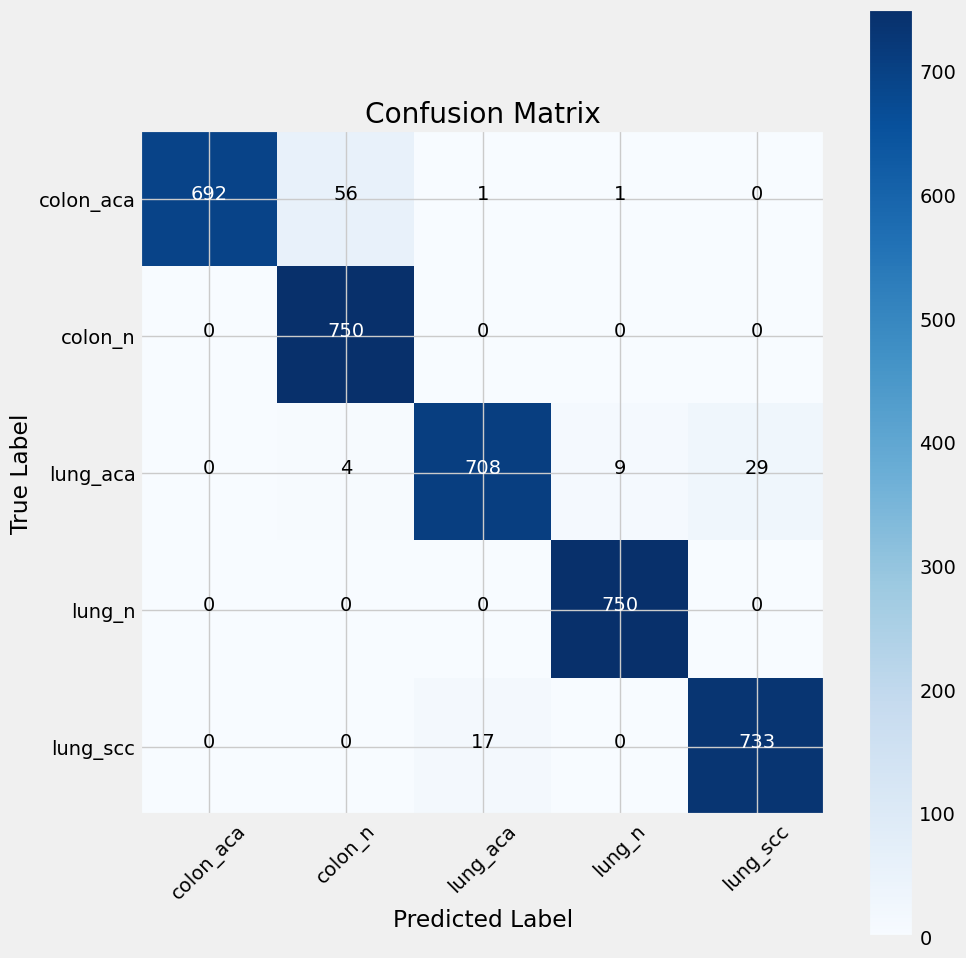

In [ ]:
y_predict_advanced = model_advanced.predict(advanced_test_gen)
confusion_matrix_plot(advanced_test_gen, y_predict_advanced)

# 6. Evaluation

In [ ]:
print(metrics_basic)

{'best_val_loss': 0.05280180275440216, 'best_val_loss_epoch': 10, 'best_val_acc': 0.9818666577339172, 'best_val_acc_epoch': 10, 'test_precision': 0.979634098486739, 'test_recall': 0.9797333333333333, 'test_f1': 0.979666392029395}


In [ ]:
print(metrics_moderate)

{'best_val_loss': 0.046967972069978714, 'best_val_loss_epoch': 10, 'best_val_acc': 0.9847999811172485, 'best_val_acc_epoch': 10, 'test_precision': 0.9781432934265113, 'test_recall': 0.9781333333333333, 'test_f1': 0.9780781415215027}


In [ ]:
print(metrics_advanced)

{'best_val_loss': 0.07311969995498657, 'best_val_loss_epoch': 9, 'best_val_acc': 0.9717333316802979, 'best_val_acc_epoch': 9, 'test_precision': 0.9699833799954358, 'test_recall': 0.9688, 'test_f1': 0.9687240688093006}
